<h1 align="center">Residual Connections in Deep Learning</h1>

## 1. Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Create a Synthetic Data

In [3]:
vocab_size = 1000
embed_dim = 128
hidden_dim = 256
num_samples = 500
seq_length = 20
num_classes = 2

In [4]:
def generate_frequency_pattern(num_samples, seq_length, vocab_size, num_classes):
    """
    Class 0: sequences with more low-frequency words (0-vocab_size//2)
    Class 1: sequences with more high-frequency words (vocab_size//2-vocab_size)
    """
    X = []
    y = []
    
    for _ in range(num_samples):
        label = np.random.randint(0, num_classes)
        
        if label == 0:
            # More words from lower half of vocabulary
            seq = torch.randint(0, vocab_size // 2, (seq_length,))
        else:
            # More words from upper half of vocabulary
            seq = torch.randint(vocab_size // 2, vocab_size, (seq_length,))
        
        X.append(seq)
        y.append(label)
    
    return torch.stack(X), torch.tensor(y)

X_train, y_train = generate_frequency_pattern(num_samples, seq_length, vocab_size, num_classes)

print(f"Training samples: {X_train.shape[0]}")
print(f"Vocabulary size: {vocab_size}")
print(f"Sequence length: {seq_length}")
print(f"Number of classes: {num_classes}")

Training samples: 500
Vocabulary size: 1000
Sequence length: 20
Number of classes: 2


## 3. Define Model Without Residual Connections

In [5]:
class TextClassifierNoResidual(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifierNoResidual, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Multiple processing layers WITHOUT residual connections
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        
        # Embed tokens
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_dim)
        
        # Average pooling over sequence
        pooled = embedded.mean(dim=1)  # (batch_size, embed_dim)
        
        # Pass through layers WITHOUT skip connections
        out = self.relu(self.fc1(pooled))
        out = self.dropout(out)
        
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        
        out = self.relu(self.fc3(out))
        out = self.dropout(out)
        
        out = self.relu(self.fc4(out))
        out = self.dropout(out)
        
        # Output layer
        out = self.fc_out(out)
        
        return out

In [6]:
model_no_residual = TextClassifierNoResidual(vocab_size, embed_dim, hidden_dim, num_classes)
print(f"Model parameters: {sum(p.numel() for p in model_no_residual.parameters())}")

Model parameters: 358914


## 4. Define Model With Residual Connections

In [7]:
class ResidualBlock(nn.Module):
    """A single residual block with skip connection"""
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Store input for skip connection
        identity = x
        
        # Process through layers
        out = self.fc(x)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Add skip connection
        out = out + identity
        
        return out

In [8]:
class TextClassifierWithResidual(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifierWithResidual, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Project embedding to hidden dimension
        self.projection = nn.Linear(embed_dim, hidden_dim)
        
        # Multiple residual blocks WITH skip connections
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        self.res_block3 = ResidualBlock(hidden_dim)
        self.res_block4 = ResidualBlock(hidden_dim)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        
        # Embed tokens
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_dim)
        
        # Average pooling over sequence
        pooled = embedded.mean(dim=1)  # (batch_size, embed_dim)
        
        # Project to hidden dimension
        out = self.relu(self.projection(pooled))
        
        # Pass through residual blocks WITH skip connections
        out = self.res_block1(out)
        out = self.res_block2(out)
        out = self.res_block3(out)
        out = self.res_block4(out)
        
        # Output layer
        out = self.fc_out(out)
        
        return out

In [9]:
model_with_residual = TextClassifierWithResidual(vocab_size, embed_dim, hidden_dim, num_classes)
print(f"Model parameters: {sum(p.numel() for p in model_with_residual.parameters())}")

Model parameters: 424706


## 5. Define Helper Function for Training

In [10]:
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    num_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Shuffle training data
        indices = torch.randperm(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Mini-batch training
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            batch_X = X_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}")
    
    return train_losses

## 6. Train Model with No Residual Connection

In [11]:
train_losses_no_res = train_model(
    model_no_residual, X_train, y_train, epochs=10
)

Epoch [1/10] - Train Loss: 0.6876
Epoch [2/10] - Train Loss: 0.4684
Epoch [3/10] - Train Loss: 0.0390
Epoch [4/10] - Train Loss: 0.0092
Epoch [5/10] - Train Loss: 0.0185
Epoch [6/10] - Train Loss: 0.0166
Epoch [7/10] - Train Loss: 0.0063
Epoch [8/10] - Train Loss: 0.0002
Epoch [9/10] - Train Loss: 0.0010
Epoch [10/10] - Train Loss: 0.0029


## 7. Train Model with Residual Connections

In [12]:
train_losses_with_res = train_model(
    model_with_residual, X_train, y_train, epochs=10
)

Epoch [1/10] - Train Loss: 0.5763
Epoch [2/10] - Train Loss: 0.1064
Epoch [3/10] - Train Loss: 0.0027
Epoch [4/10] - Train Loss: 0.0001
Epoch [5/10] - Train Loss: 0.0001
Epoch [6/10] - Train Loss: 0.0000
Epoch [7/10] - Train Loss: 0.0000
Epoch [8/10] - Train Loss: 0.0000
Epoch [9/10] - Train Loss: 0.0000
Epoch [10/10] - Train Loss: 0.0000


In [13]:
print(f"Final Training Loss (No Residual): {train_losses_no_res[-1]:.4f}")
print(f"Final Training Loss (With Residual): {train_losses_with_res[-1]:.4f}")

Final Training Loss (No Residual): 0.0029
Final Training Loss (With Residual): 0.0000


## Visualize Result

In [14]:
sns.set_style("darkgrid")

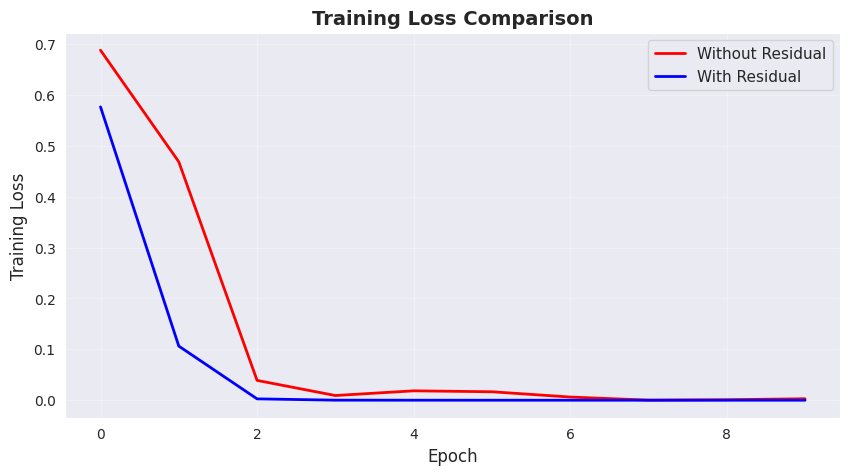

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_no_res, label='Without Residual', linewidth=2, color='red')
plt.plot(train_losses_with_res, label='With Residual', linewidth=2, color='blue')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.show()